# Bridging Neural Dynamics: extending TRFs - Part 1

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Hugo-W/CNSP25_tutorial_HWeissbart/main/)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Hugo-W/CNSP25_tutorial_HWeissbart/blob/main/notebooks/part_1.ipynb)

Firstly, let's review our intuitive understanding behind Temporal Response Functions (TRF), we will start by simulating signals, building our ground truth TRFs and convolve them with our own designed feature signals. This will allow us to observe in particular why one may say that we do not need regularisation for impulse-like features for instance.

### Setup (Google Colab only)

> We need an extra step to make sure widgets can work in Collab notebooks, uncomment and run the cell bellow if using Google Collab, otherwise just skip this.

In [ ]:
try:
  import google.colab # type: ignore
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %pip install -q ipywidgets ipympl
    %pip install -q natmeeg
    print("🔁 Restarting kernel to use newly installed packages... Just wait that the kernel restarts, then start by running the cell below.")
    get_ipython().kernel.do_shutdown(True) # type: ignore

In [ ]:
import sys
if IN_COLAB and 'natmeeg' not in sys.modules:
    print("🔁 Restarting kernel to use newly installed packages...")
    get_ipython().kernel.do_shutdown(True) # type: ignore

In [ ]:
try:
  import google.colab # type: ignore
  IN_COLAB = True
except:
  IN_COLAB = False
  
# Download `utils`
if IN_COLAB:
    import requests
    import os

    files = ['__init__.py', 'helpers.py', 'surrogate.py', 'visu.py', 'utils.py']
    # Create utils directory if it doesn't exist
    os.makedirs('utils', exist_ok=True)
    for f in files:
        url = f'https://raw.githubusercontent.com/Hugo-W/CNSP25_tutorial_HWeissbart/main/utils/{f}'
        response = requests.get(url)

        with open(f'utils/{f}', 'wb') as f:
            f.write(response.content)

    # Also download mpl-tstyle:
    url = 'https://raw.githubusercontent.com/Hugo-W/CNSP25_tutorial_HWeissbart/main/notebooks/dark.mplstyle'
    response = requests.get(url)
    with open('./dark.mplstyle', 'wb') as f:
       f.write(response.content)

    from google.colab import output # type: ignore
    output.enable_custom_widget_manager()

## Imports

First let's get all the libraries, data and path setup.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import VBox, HBox, HTML, HTMLMath, Checkbox, FloatSlider, IntSlider, Dropdown, interact, Button, Dropdown
import tqdm.notebook as tqdm
import sys, os
# Add utils to Python path
sys.path.append('..') # access to utils.py and visu.py modules
from utils.utils import download_file, list_h5_data
from utils.visu import plot_fft
from utils.surrogate import (simulate_background_eeg, simulate_band_power, simulate_regular_events,
                             simulate_smooth_signal, create_kernel)
from utils.helpers import lowpass_filter, convolve_with_kernel, lag_matrix, lag_span, _svd_regress, conjugate_gradient_solver
from utils.helpers import convolve_with_kernel, lag_matrix, lag_span, _svd_regress

from scipy.signal import filtfilt, butter, welch

# For darkbackground:
plt.style.use('dark.mplstyle')

%matplotlib widget

In [3]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
</style>

## Simulating input and response signals

We will first simulate different input signals:
- A series of impulses (akin to word or phoneme onsets)
- A series of **valued** impulses (akin to word surprisal)
- A smooth continuous signal (akin to a sound envelope)

In [4]:
# Parameters
rng = np.random.default_rng(2025)  # for reproducibility
fs = 100  # Sampling rate in Hz
duration = 30  # Duration in seconds
tmin = -0.2  # Kernel start time in seconds
tmax = 0.6  # Kernel end time in seconds
n_samples = int(fs * duration)  # Total number of samples

N events: 194.0


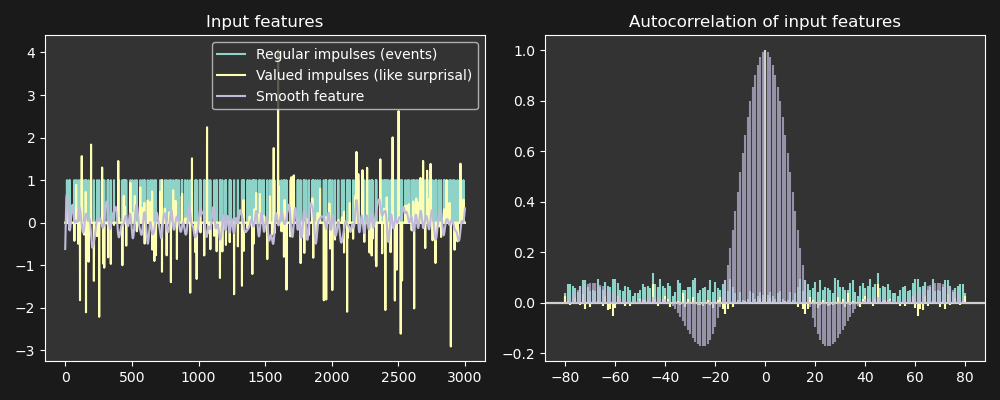

In [5]:
plt.close('Stimulus')
impulses = simulate_regular_events(interval=0.15, jitter=0.1)
valued_impulses = impulses * rng.normal(size=impulses.shape)
print(f"N events: {np.sum(impulses)}")

# Cutoff for smoothing
fc = 3.  # Hz
# Design the Butterworth lowpass filter
b, a = butter(4, fc, fs=100)
smoothed_signal = filtfilt(b, a, rng.normal(size=impulses.shape))
# smoothed_signal = filtfilt(b, a, valued_impulses)*8.

fig, ax = plt.subplots(1, 2, figsize=(10, 4), num='Stimulus')
ax[0].plot(impulses       , label='Regular impulses (events)')
ax[0].plot(valued_impulses, label='Valued impulses (like surprisal)')
ax[0].plot(smoothed_signal, label='Smooth feature')
ax[0].set_title('Input features')
ax[0].legend()

# Autocorrelation functions fo features:
ax[1].acorr(impulses       , maxlags=80, label='Regular impulses (events)', color='C0')
ax[1].acorr(valued_impulses, maxlags=80, label='Valued impulses (like surprisal)', color='C1')
ax[1].acorr(smoothed_signal, maxlags=80, label='Smooth feature', color='C2', alpha=0.7)
ax[1].set_title('Autocorrelation of input features')
plt.tight_layout()


Then, let's simulate three different kernels to play with, these will be our _ground truth_ Temporal Response Functions.

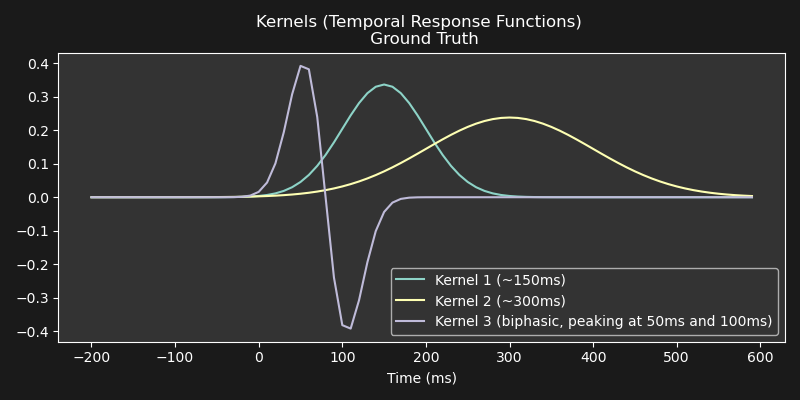

In [6]:
plt.close('Kernels')

# Create three different kernels
tker, ker1 = create_kernel(loc=0.15, spread=0.05) # A fast response
_, ker2 = create_kernel(loc=0.3, spread=0.1) # a longish response
_, ker3 = create_kernel(loc=0.08, spread=0.025, bipolar=True) # an even faster response with N1/P2 morphology

plt.figure('Kernels', figsize=(8, 4))
plt.plot(tker*1e3, ker1, label='Kernel 1 (~150ms)')
plt.plot(tker*1e3, ker2, label='Kernel 2 (~300ms)')
plt.plot(tker*1e3, ker3, label='Kernel 3 (biphasic, peaking at 50ms and 100ms)')
plt.title('Kernels (Temporal Response Functions) \n Ground Truth')
plt.xlabel('Time (ms)')
plt.legend()
plt.tight_layout()


Finally, by convolving the input signals with the kernels one can generate our response signal. We can then add noise to it ro make it more M/EEG like adding background $1/f$ noise and adding power in the alpha band.

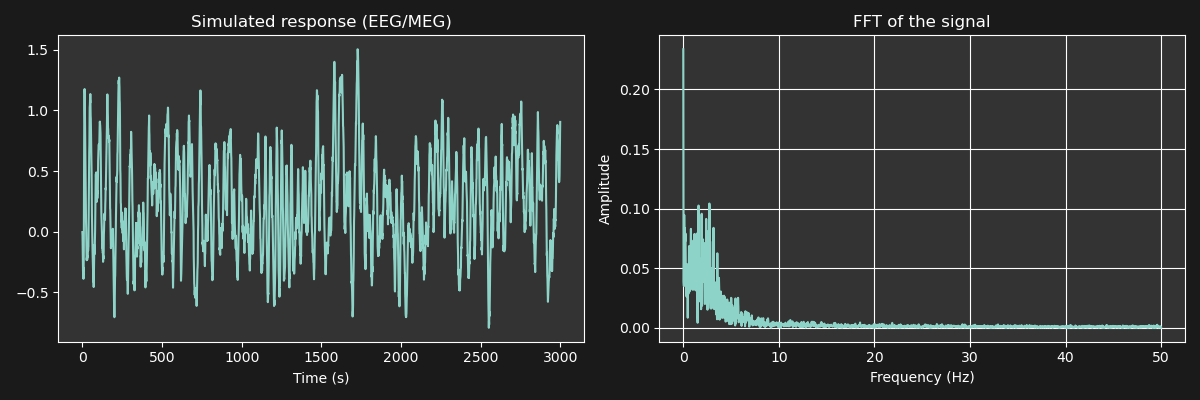

In [7]:
trf_params = {
    'tmin': tmin,
    'tmax': tmax,
    'fs': fs,
}
resp = convolve_with_kernel(impulses, ker1, **trf_params)
resp += convolve_with_kernel(valued_impulses, ker2, **trf_params)
resp += convolve_with_kernel(smoothed_signal, ker3, **trf_params)
# Add some noise and "alpha power":
alpha_contrib = 0.
one_over_f_contrib = .05
resp += simulate_background_eeg(alpha=0.9, fs=fs)*one_over_f_contrib + alpha_contrib*simulate_band_power(sampling_rate=fs, duration=duration,)

# Visualisation
plt.close('Response')
f, ax = plt.subplots(1, 2, figsize=(12, 4), num='Response')
ax[0].plot(resp)
ax[0].set_title('Simulated response (EEG/MEG)')
ax[0].set_xlabel('Time (s)')
plot_fft(resp, fs=fs, ax=ax[1])
plt.tight_layout()

We can very easily estimate the TRF using ordinary least squares or Ridge regression. Let's briefly recap the maths...

Firstly, we recall that one can rewrite the discrete (and finite time) convolution in a vectorized format by designing a matrix of features $\mathbf{X} \in \mathbb{R}^{N\times k}$ (with $N$ samples, and $k=d\times n_{lags}$, for $d$ features and $n_{lags}$ lags considered in the convolution). Thus, we are reformulating $\hat{\mathbf{y}}(t) = \sum_d \left\{ x_d(t) \star \beta \right\}(t) = \sum_d \sum_{\tau} x_d(t-\tau) \beta(\tau)$ as $\hat{\mathbf{Y}} = \mathbf{X}\beta$, a simple linear formulation of the model (in the form of $AX=B$).

We know that for $N \gt k$, meaning that $\mathbf{X}$ is not square and rather longer than wider, **no exact solution exists**, but one can find a **unique solution** to the optimisation problem which tries to minimise the least-squared error between estimated $\hat{\mathbf{Y}}$ and the true $\mathbf{Y}$. There is another way to arrive to the same unique _least-square_ solution, by passing through the _normal equation_ which looks at another linear equation but this time with "$\mathbf{A}$" being square:

\begin{align}
\mathbf{Y} &= \mathbf{X}\beta\\
\mathbf{X^T}\mathbf{Y} &= \mathbf{X^T}\mathbf{X}\beta\\
\nonumber\\ 
\beta_{OLS} &= \left(\mathbf{X^T}\mathbf{X}\right)^{-1}\mathbf{X^T}\mathbf{Y}\\
\end{align}

Equation (3) is solution to (2), and it also corresponds to the least-square solution (minimising the squared error). Now $\mathbf{X}^T\mathbf{X}$ is indeed a square matrix, thus invertible if all its eigenvalues are strictly non-zero (actually positive, as it's a symmetric matrix anyway). The fact is that **numerically** the eigenvalues will **never exactly be zero** so we will always be able to compute this solution. But this is not necessarily good, and it is exactly what we mean by **fitting the noise/overfitting/...**. A simple solution is to shift it seigenvalues away from zero by adding "weight" to the diagonal of $\mathbf{X}^T\mathbf{X}$ (i.e. creating a more pronounced "ridge" in the matrix):

$$
\beta_{ridge} = \left(\mathbf{X^T}\mathbf{X} + \lambda I_k\right)^{-1}\mathbf{X^T}\mathbf{Y}
$$

Here we described exactly the solution to the Ridge regression problem, with a new term $\lambda I_k$, the _regularising_ term, also known as a Tikhonov regularisation.

> The question is really: _what give rise to small/close-to-zero eigenvalues of $\mathbf{X}^T\mathbf{X}$?_

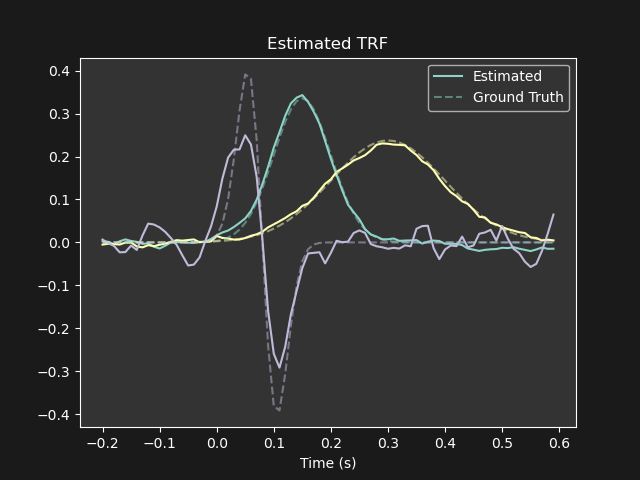

In [8]:
# First we create the multi-dimensional feature vector
x = np.c_[impulses, valued_impulses, smoothed_signal]
# Then we create the lagged version of it: X
lags = lag_span(-0.2, 0.6, srate=100) + 1 # shifted because of how lag_span uses `np.ceil`
X = lag_matrix(x, lags)

# Now we can estimate the TRF using simple linear regression
alpha = 1.0
proj = np.linalg.inv(X.T @ X + alpha * np.eye(X.shape[1])) @ X.T
beta = proj @ resp
beta = beta.reshape(len(lags), x.shape[1], order='F')
plt.close('TRF')
plt.figure('TRF')
lines = plt.plot(tker, beta)
gt_lines = plt.plot(tker, np.c_[ker1, ker2, ker3], linestyle='--', alpha=0.5)
for l, g in zip(lines, gt_lines):
    g.set_color(l.get_color()) # match colors
# Legend for - and --, but with dummy lines:
plt.legend([lines[0], gt_lines[0]], ['Estimated', 'Ground Truth'])
plt.title('Estimated TRF')
plt.xlabel('Time (s)');

Let's try different values for our regularisation $\alpha$ (in the code we use `alpha` simply to avoid the built-in python name `lambda`) and see how it affects the content of the estimated TRF in terms of frequency spectrum. We will observe that _somehow_, increasing the regularising parameter acts as a low-pass filter...

Also note the effect of regularisation on TRF for impulse-related features: they only scale them down.

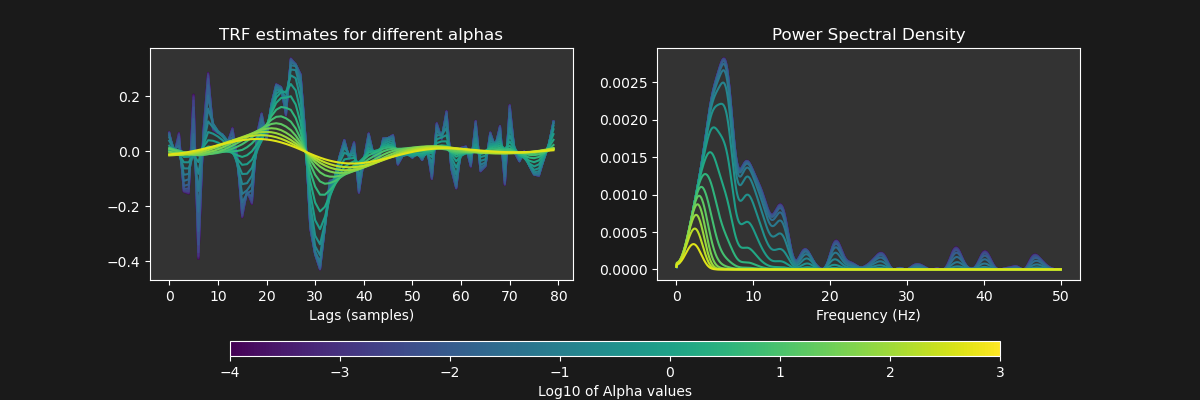

In [9]:
alphas = np.logspace(-4, 3, 20)
beta = _svd_regress(X, resp[:, None], alpha=alphas).squeeze()

# Visualisation
feature = 2 # which feature to plot
plt.close('TRF_alphas')
f, ax = plt.subplots(1, 2, figsize=(12, 4), num='TRF_alphas')
for k, b in enumerate(beta.T):
    color = plt.cm.viridis(k / len(alphas))
    ax[0].plot(b.reshape(len(lags), x.shape[1], order='F')[:, feature], color=color)
    freqs, psd = welch(b.reshape(len(lags), x.shape[1], order='F')[:, feature], fs=fs, nperseg=len(lags), nfft=2048)
    ax[1].plot(freqs, psd, color=color)
ax[0].set_title('TRF estimates for different alphas')
ax[1].set_title('Power Spectral Density')
ax[0].set_xlabel('Lags (samples)')
ax[1].set_xlabel('Frequency (Hz)')
log_alphas = np.log10(alphas)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=log_alphas.min(), vmax=log_alphas.max())), ax=ax,
                    orientation='horizontal', label='Log10 of Alpha values', aspect=50, fraction=0.05, pad=0.2)
f.subplots_adjust(bottom=0.3)


Let's now directly look into how $\mathbf{X}.T\mathbf{X}$ look for different feature type, and how the eigenvalue spectra change for each.

> Note that in algebra, the ratio of the largest eigenvalue over the smallest eigenvalue is called the **condition number** of the matrix. A high condition number indicates ill-conditioning, which means that the matrix is close to being singular (not invertible). In practical terms, ill-conditioning implies that small changes in the data can lead to large changes in the solution, which will necessitate the use of regularization such as Ridge Regression to stabilize the inversion of matrices during model estimation.

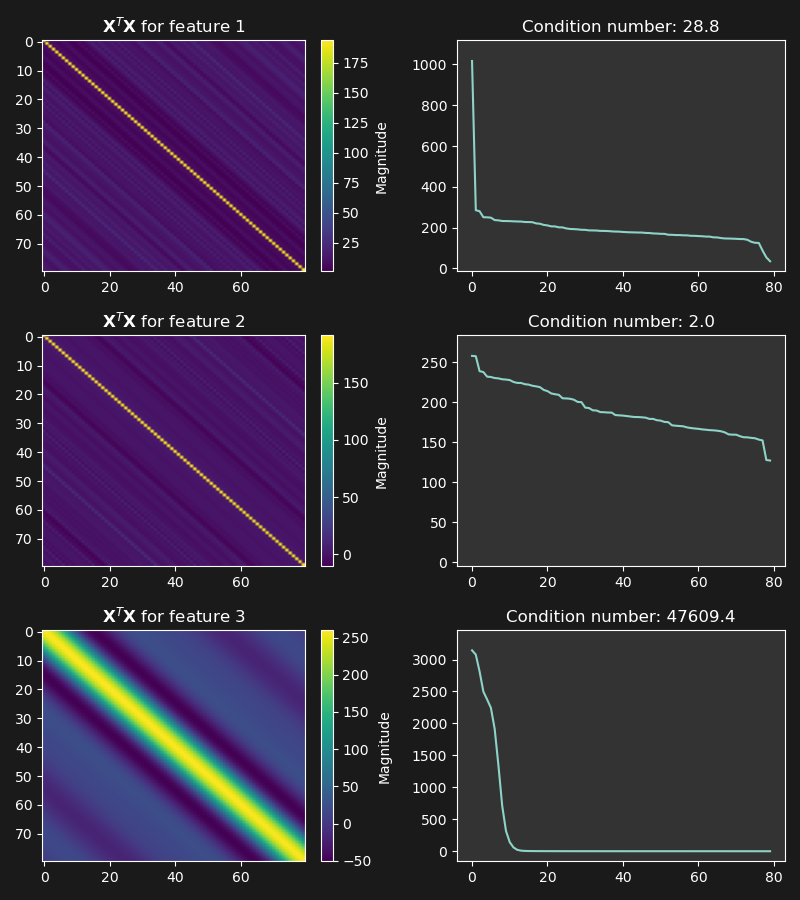

In [10]:
nlags = len(lags)
nfeatures = x.shape[1]

fc = 5.  # Hz
# Design the Butterworth lowpass filter
b, a = butter(4, fc, fs=100)
smoothed_signal = filtfilt(b, a, rng.normal(size=impulses.shape))
x[:, 2] = smoothed_signal
X = lag_matrix(x, lags)

plt.close('XtX')
f, ax = plt.subplots(nfeatures, 2, figsize=(8, 3*nfeatures), num='XtX')
for k in range(nfeatures):
    im = ax[k, 0].imshow(X[:, k*nlags:(k+1)*nlags].T @ X[:, k*nlags:(k+1)*nlags], aspect='auto', cmap='viridis')
    plt.colorbar(im, label='Magnitude', ax=ax[k, 0])
    ax[k, 0].set_title(r'$\mathbf{X}^T\mathbf{X}$ for feature '+str(k+1))
    evals = np.linalg.eigvalsh(X[:, k*nlags:(k+1)*nlags].T @ X[:, k*nlags:(k+1)*nlags])[::-1]
    ax[k, 1].plot(evals)
    ax[k, 1].set_title(f'Condition number: {evals[0]/evals[-1]:.1f}')
    # ax[k, 1].set_yscale('log')
    ax[k, 1].set_ylim(min(ax[k, 1].get_ylim()[0], -5), evals.max()*1.1)
plt.tight_layout()

## Putting it all together: TRF Explorer

Let's wrap all these plots in an interactive figure so we can directly assess the consequence of change made to signals characteristics.

In [ ]:
# Create a nice looking intecative plot using HTML and ipywidgets
%matplotlib widget
plt.ioff()  # Turn off interactive mode to prevent double plotting
display(
    HTML("""
<style>
.my-label-style label {
    color: white !important;
}
</style>
"""
))

# Initial setup of the figure and axes
plt.close('TRF Explorer')
fig, axes = plt.subplots(2, 4, figsize=(12, 6), num='TRF Explorer')
gs = axes[0, 0].get_gridspec()
for ax in axes[0, :]:
    ax.remove()
ax_sig = fig.add_subplot(gs[0, 0:2])
ax_trf = fig.add_subplot(gs[0, 2:])
for ax in axes[1, :2]:
    ax.remove()
ax_fft = fig.add_subplot(gs[1, 0:2])
ax_xtx = axes[1, 2:]
plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.3)
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.layout.min_width = '800px'
fig.canvas.layout.min_height = '600px'

# Initialise plots and data

# Signals
pulses = simulate_regular_events(interval=0.3, jitter=0.025)
valued = pulses * rng.normal(size=pulses.shape)
smooth = lowpass_filter(valued, cutoff=8., fs=fs)
tker, kernel = create_kernel(bipolar=True)
lags = lag_span(tmin=-0.2, tmax=0.6, srate=fs) + 1
resp = convolve_with_kernel(pulses, kernel, tmin=-0.2, tmax=0.6, fs=fs)
snr = 3
sigma = np.std(resp) / snr
resp += rng.normal(0, sigma, size=resp.shape)
time = np.arange(0, 30., 1/fs)
# TRF
x = np.c_[pulses]
X = lag_matrix(x, lags)
XtX = X.T@X
alpha = 0.
beta = np.linalg.inv(XtX + alpha*np.eye(len(lags))) @ X.T @ resp

# Plot signals
resp_line, = ax_sig.plot(time, resp * 5., label='Response signal')
stim_line, = ax_sig.plot(time, pulses, color='crimson', label='Stimulus')
ax_sig.set_xlim(0, 10)
ax_sig.set_xlabel('Time (s)')
ax_sig.set_title('Signals')
ax_sig.legend()
# Plot TRFs
line_trf, = ax_trf.plot(tker*1e3, beta, label='TRF')
line_ker, = ax_trf.plot(tker*1e3, kernel, label='Ground truth', ls='--')
ax_trf.legend()
ax_trf.axvline(0., color=plt.rcParams['axes.edgecolor'], lw=1.)
ax_trf.set_xlabel('Time (ms)')
# Spectra
plot_fft(resp, fs=fs, ax=ax_fft)
plot_fft(beta, fs=fs, ax=ax_fft)
# XtX
im_xtx = ax_xtx[0].imshow(XtX)
evals = np.linalg.eigvalsh(XtX)[::-1]
eig_spectrum, = ax_xtx[1].plot(evals)
ax_xtx[1].set_title(f"Condition number: {evals[0]/evals[-1]:.1f}")

# Make widget boxes for layout
header = HTML(
    value="<h2>TRF Explorer</h2>"
          "This interactive figure allows you to explore how different parameters affect the estimated TRFs and the resulting EEG signal."
)
text_instructions = HTML(
    value="<b>Instructions:</b> Use the sliders and dropdowns to adjust parameters. "
          "The plots will update automatically to reflect your changes."
)
header.style.text_color = 'white'
text_instructions.style.text_color = 'white'

# Create widget controls
slider_impulse_interval = FloatSlider(value=0.3, min=0.01, max=1.0, step=0.01, description='Spike Interval (s):', continuous_update=True)
stim_type = Dropdown(options=['Event onsets', 'Valued pulses', 'Smooth signal'], value='Event onsets', description='Stimulus type:')
slider_snr = FloatSlider(value=3, min=-2.0, max=5.0, step=0.5, description='SNR (log-scale):', continuous_update=True)
slider_cutoff = FloatSlider(value=8., min=2.0, max=25.0, step=0.3, description='Cutoff (Hz):', continuous_update=True)
slider_lambda = FloatSlider(value=-1., min=-6.0, max=4.0, step=0.5, description='Regularisation (log-scale):', continuous_update=True)
checkbox_regularise = Checkbox(True, description="Apply regularisation: ")
button_reset = Button(description='Reset Parameters')

# Function to reset parameters to default values
def reset_parameters(b):
    slider_impulse_interval.value = 0.3
    stim_type.value = 'Event onsets'
    slider_snr.value = 3
    slider_cutoff.value = 8.
    slider_lambda.value = -1.
    checkbox_regularise.value = True    
button_reset.on_click(reset_parameters)

# Function to update plots based on widget values
def update_plots(pulse_interval, stim_type, snr, fc, alpha):
    # # Clear previous plots
    # for ax in axes.flatten():
    #     ax.clear()

    pulses = simulate_regular_events(interval=pulse_interval, jitter=0.025)
    valued = pulses * rng.normal(size=pulses.shape)
    smooth = lowpass_filter(valued, cutoff=fc, fs=fs)
    if stim_type == 'Event onsets':
        stim = pulses
    elif stim_type == 'Valued pulses':
        stim = valued
    else:
        stim = smooth
    resp = convolve_with_kernel(stim, kernel, tmin=-0.2, tmax=0.6, fs=fs)
    sigma = np.std(resp) / 10**snr
    resp += rng.normal(0, sigma, size=resp.shape)
    x = np.c_[stim]
    X = lag_matrix(x, lags)
    XtX = X.T@X
    evals = np.linalg.eigvalsh(XtX)[::-1]

    beta = np.linalg.inv(XtX + alpha*np.eye(len(lags))) @ X.T @ resp

    # Update line plots
    stim_line.set_ydata(stim)
    resp_line.set_ydata(resp)
    line_trf.set_ydata(beta)
    im_xtx.set_data(XtX)
    im_xtx.set_clim(np.min(XtX), np.max(XtX))
    eig_spectrum.set_ydata(np.linalg.eigvalsh(XtX)[::-1])
    ax_xtx[1].axes.relim()
    ax_xtx[1].autoscale_view(scaley=True)
    ax_xtx[1].set_title(f"Condition number: {evals[0]/evals[-1]:.1f}")
    ax_fft.clear()
    plot_fft(stim, fs=fs, ax=ax_fft)
    plot_fft(beta, fs=fs, ax=ax_fft)

    fig.canvas.draw_idle()

# assign update function
for w in [slider_impulse_interval, stim_type, slider_snr, slider_cutoff, slider_lambda, checkbox_regularise]:
    w.observe(lambda change: update_plots(slider_impulse_interval.value,
                                                                stim_type.value,
                                                                slider_snr.value,
                                                                slider_cutoff.value,
                                                                10**slider_lambda.value if checkbox_regularise.value else 0),
                                    names='value')

# Layout
text = VBox([header, text_instructions])
widgets = HBox([
     VBox([stim_type, slider_impulse_interval, slider_cutoff]),
     VBox([checkbox_regularise, slider_lambda, slider_snr])
])
VBox([text, widgets, button_reset, fig.canvas])

HTML(value='\n<style>\n.my-label-style label {\n    color: white !important;\n}\n</style>\n')

## Phase-Amplitude couplings with TRF

How to compute phase-amplitude relationship, such as coherence based measure and phase-locking to amplitude modulation in **continuous settings, while disentangling the effect of different stimulus feature**?

### PAC: a short recap

One easy way to measure such couplings is simply by looking at the phase of a slow oscillator $\phi_{slow}$ in relation with the amplitude of a faster one $\rho_{fast}$ such as, e.g. slow and fast being $\delta$ and $\beta$, computed as the mean vector length of the compound analytical signal:

$$
C(\delta, \beta) = | \frac{1}{N}\sum_{i=1}^N{\phi_{\delta}(t) \times \rho_{\beta}(t)} |\\
                 = | \frac{1}{N}\sum_{i=1}^N{\rho_{\beta}(t)e^{i\theta(t)}} |\\
$$


In [this paper](https://www.frontiersin.org/articles/10.3389/fnins.2017.00487/full), there is a comparison for those measures:
- Mean-Vector Length modulation index, originally described in Canolty et al. (2006):
$$
C(\delta, \beta) = | \frac{1}{N}\sum_{i=1}^N{\rho_{\beta}(t)e^{i\theta(t)}} |
$$
- Mean-Vector Length modulation index described in Özkurt and Schnitzler (2011):
$$
C(\delta, \beta) = | \frac{1}{\sqrt{N}}\frac{\sum_{i=1}^N{\rho_{\beta}(t)e^{i\theta(t)}}}{\sqrt{\sum{\rho(t)^2}}} |
$$
- phase-locking value modulation index described in Cohen (2008):
$$
C(\delta, \beta) = | \frac{1}{N}\sum_{i=1}^N{e^{i(\theta(t) - \phi{\rho(t)})}} |
$$
- the Kullback-Lieber modulation index described in [Tort et al. (2010b)](https://journals.physiology.org/doi/full/10.1152/jn.00106.2010)
$$
C(\delta, \beta) = | \frac{KL(D||Q)}{\log(N_{bins})} |
$$

In [2]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
from scipy.signal import hilbert
from tqdm.notebook import tqdm
from collections import namedtuple

MI = namedtuple('modulation_index', ['mean_vector', 'normalised_mean_vector', 'plv', 'kl'])

import sys
sys.path.append('..')
from utils.utils import normalize_complex, check_complex

# Set up style if using dark background
dark_bg = True
if dark_bg:
    plt.style.use('dark.mplstyle')

plt.close('all')
%matplotlib inline

In [3]:
def compute_amp_phase_distribution(amp, phase, n_bins=18):
     # If complex input, take amplitude and phase angle manually first                                                                                       
    amp, phase = check_complex(amp, phase)                                                                                                                            
                                                                                                                                                            
    # Phase must be between 0 and 2 pi                                                                                                                      
    phase = phase%(2*np.pi) #+ np.pi * (1-np.sign(phase))
    bin_edges = np.linspace(0, 2*np.pi, n_bins+1)                                                                                                           
    amp_pmf = np.zeros((n_bins,))                                                                                                                           
    binned_count = np.zeros((n_bins,)) # to take the mean of amplitude values per bin                                                                       
    for r, phi in zip(amp, phase):                                                                                                                          
        bin_idx = np.argmin(abs(bin_edges - phi))%n_bins                                                                                                    
        amp_pmf[bin_idx] += r                                                                                                                               
        binned_count[bin_idx] += 1                                                                                                                          
    # Take average amplitude per bin                                                                                                                        
    amp_pmf[binned_count!=0] /= binned_count[binned_count!=0]                                                                                               
                                                                                                                                                            
    # Normalize to get a probability distribution                                                                                                           
    amp_pmf /= amp_pmf.sum()
    
    # Bin centers:
    bins = bin_edges[:-1] + np.diff(bin_edges)/2
    
    return amp_pmf, bins

def modulation_index_tort2010(amp, phase, n_bins=18):
    """
    Modulation index as computed with the KL divergence, see Tort et al. (2010).
    """                                                                                                                                                                                                                                               
    amp_pmf, bins = compute_amp_phase_distribution(amp, phase, n_bins)                                                                                                                                
                                                                                                                                                            
    entropy = -np.sum(amp_pmf[amp_pmf!=0] * np.log(amp_pmf[amp_pmf!=0]))                                                                                    
                                                                                                                                                            
    return 1-entropy/np.log(n_bins) # = DL(P(r) ; Uniform)/log(n)

def modulation_index_canolty2006(amp, phase):
    # If complex input, take amplitude and phase angle manually first                                                                                       
    amp, phase = check_complex(amp, phase)
    return np.abs(np.mean(amp * np.exp(1j*phase)))

def modulation_index_ozkurt2011(amp, phase):
    # If complex input, take amplitude and phase angle manually first                                                                                       
    amp, phase = check_complex(amp, phase)
    return np.abs(np.sum(amp * np.exp(1j*phase))/np.sqrt(np.sum(np.square(amp)))/np.sqrt(len(phase)))

def modulation_index_cohen2008_PLV(amp, phase):
    # If complex input, take amplitude and phase angle manually first                                                                                       
    amp, phase = check_complex(amp, phase)
    amp_phase = np.angle(hilbert(amp))
    return np.abs(np.mean(np.exp(1j*(phase - amp_phase))))

def compute_all_MI(amp, phase):
    return MI(modulation_index_canolty2006(amp, phase),
              modulation_index_ozkurt2011(amp, phase),
              modulation_index_cohen2008_PLV(amp, phase),
              modulation_index_tort2010(amp, phase))

##### Simulations

In [4]:
fs = 200
dur = 60 # 2 min duration
f_slow = 3.5 # Hz
f_fast = 20. # Hz
t = np.arange(0, dur, 1/fs)
lags = np.arange(-0.2, 0.6, 1/fs)

def generate_modulated_signal(t, mod_factor, f_slow=4, f_fast=35, noise=0.2):
    """
    This function generate a PAC irrespective of events onsets timing or values.

    Returns the main signals of interest:
      - slow phase signal
      - modulated signal
      - modulating envelope (based on slow phase but shitfing it to positive values, adding noise and gating through modulation factor)
      - carrier
    """
    phase_sig = np.sin(2*np.pi*f_slow*t)
    carrier_fast = np.sin(2*np.pi*f_fast*t)
    envelope = abs(1 + mod_factor * phase_sig + np.random.randn(*phase_sig.shape) * noise)
    # "Always on" modulation
    pac_signal = envelope * carrier_fast
    return phase_sig, pac_signal, envelope, carrier_fast

def generate_event_modulated_signal(t, env_fast, carrier_fast, Neve=200):
    """
    This function generate a PAC that occurs specifically at events onsets and scale with values.

    We will generate also a random event sequence with random values.

    Returns
    -------
    - a PAC signal for each event structure/feature type
    - always one pulses (word onset -like)
    - valued pulses ('surprisal'-like)
    - modulators for the above two features
    """
    # events structure
    idx = np.random.choice(np.arange(len(t)), size=(Neve,), replace=False)
    onsets = np.zeros_like(t)
    valued = np.zeros_like(onsets)
    onsets[idx] = 1
    valued[idx] = abs(np.random.randn(Neve,))

    # Modulation kernel
    lags = np.arange(-0.2, 0.6 + 1/fs, 1/fs)
    kernel = norm.pdf(lags, loc=0.1, scale=0.05)
    kernel /= np.std(kernel)

    # Simulate modulation time-series
    lag_samples = np.round(fs*lags).astype(int)
    modulator_onset = np.convolve(onsets.flatten(), np.pad(kernel, (max(lag_samples)+min(lag_samples), 0)), mode='same')
    modulator_value = np.convolve(valued.flatten(), np.pad(kernel, (max(lag_samples)+min(lag_samples), 0)), mode='same')

    # modulation is stronger at certain events
    signal_fast_onset = env_fast * modulator_onset * carrier_fast

    # modulation depends on external value
    signal_fast_val = env_fast * carrier_fast * modulator_value
    
    return signal_fast_onset, signal_fast_val, onsets, valued, modulator_onset, modulator_value

##### Plotting

In [5]:
from utils.visu import plot_phase_amp_distribution, plot_sig, multiple_formatter

def plot_complex_circle(signal_slow, signal_fast, ax=None, **kwargs):
    if ax is None:
        f, ax = plt.subplots(1, 1, subplot_kw={'projection':'polar'})
    amp, phase = check_complex(abs(hilbert(signal_fast)), normalize_complex(hilbert(signal_slow)))
    ax.plot(phase, amp, **kwargs) # amp*np.exp(1j*phase)
    # Add mean vector:
    mean_vect = np.mean(amp * np.exp(1j*np.angle(normalize_complex(hilbert(signal_slow)))))
    l = ax.plot([0, np.angle(mean_vect)], [0, abs(mean_vect)], color='crimson', lw=2.5)
    ax.set_title(f"Mean vector length = {abs(mean_vect):.2f}", pad=0.05)
    # Removing y-labels and reformatting in radians and multiple of pi/4
    ax.xaxis.set_major_formatter(multiple_formatter(denominator=4))
    ax.set_yticklabels([])
    return l

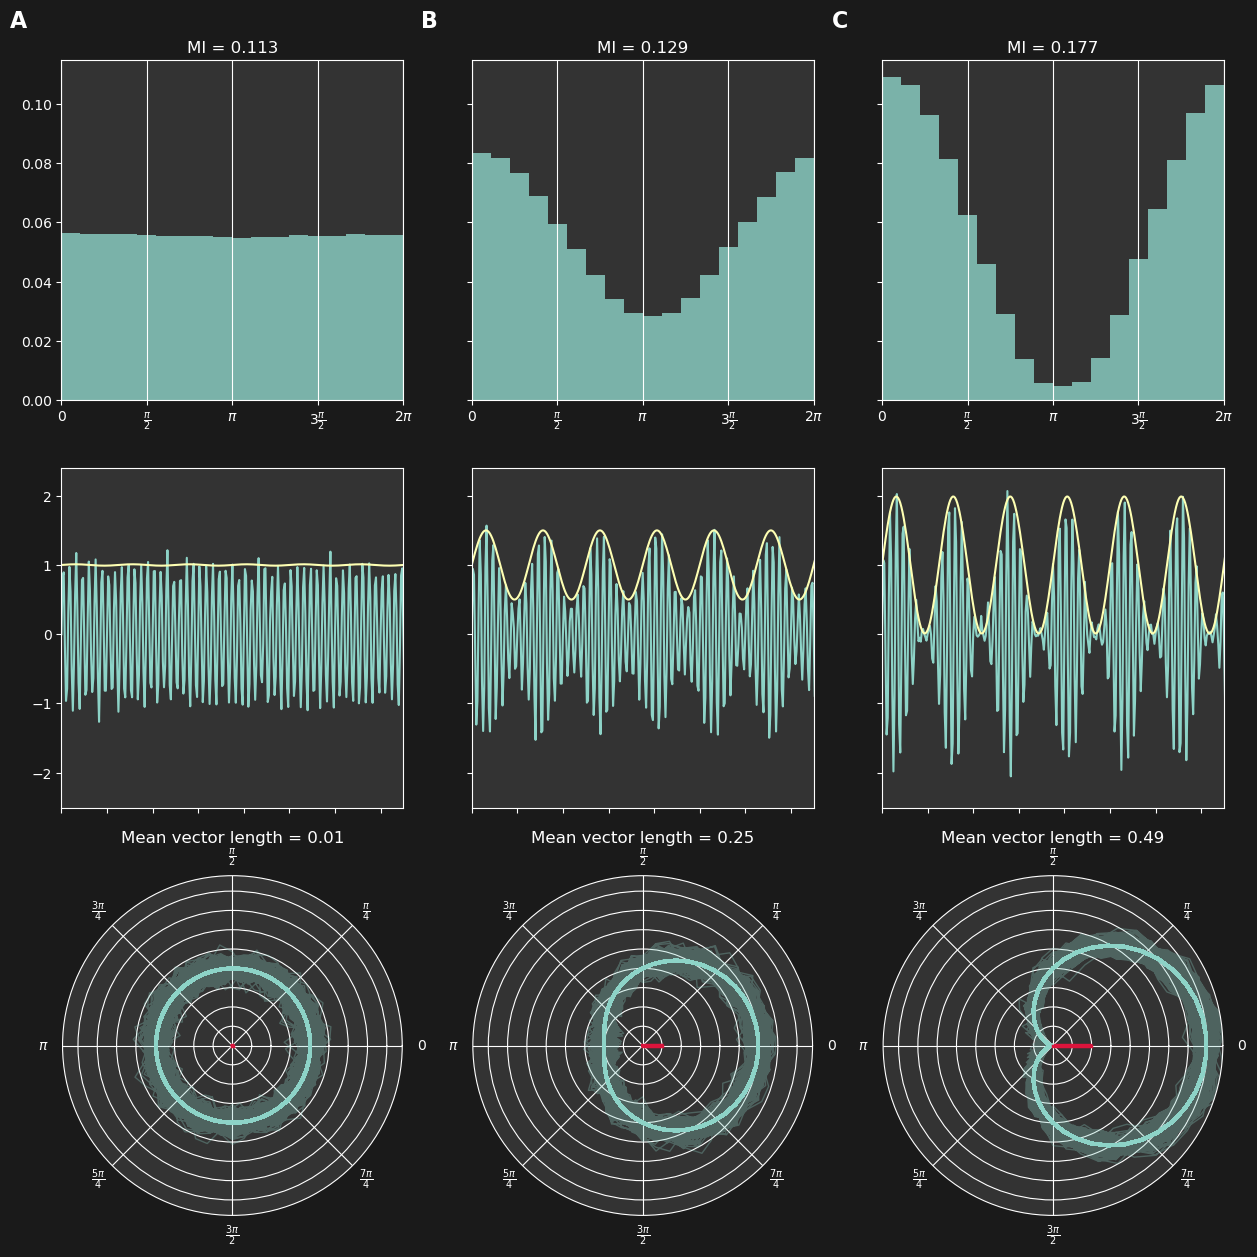

In [6]:
mods = [0.01, 0.5, 0.99]
f, ax = plt.subplots(3, 3, figsize=(15, 15), sharey='row')
for k, m in enumerate(mods):
    # Some basic example
    signal_slow, signal_fast, env_fast, carrier_fast = generate_modulated_signal(t, m, noise=0.1)
    clean_env = abs(1 + m * signal_slow)
    signal_fast_onset, signal_fast_val = generate_event_modulated_signal(t, env_fast, carrier_fast)[:2]

    # Compute emprically phase of slow signal and amplitude (envelope) of fast one
    phase_slow = normalize_complex(hilbert(signal_slow))
    amp_fast = np.abs(hilbert(signal_fast))
    # Phase-amplitude distribution
    amp_pmf, phase_bins = compute_amp_phase_distribution(amp_fast, phase_slow)
    
    ###### Plots ##########
    # 1. Phase-Amplitude Distribution
    plot_phase_amp_distribution(phase_bins, amp_pmf, ax=ax[0, k])
    ax[0, k].set_title(f"MI = {modulation_index_tort2010(amp_pmf, phase_bins):.3f}")
    # 2. Signal and the modulating envelope
    plot_sig(t, signal_fast, clean_env, ax=ax[1, k])
    ax[1, k].set_xticklabels([])
    # 3. Circular plots (need to recreate axes)
    ax[2, k].remove()
    ax[2, k] = f.add_subplot(3, 3, 2*3+1+k, projection='polar')
    plot_complex_circle(signal_slow, signal_fast, lw=1, alpha=0.3, ax=ax[2, k])
    plot_complex_circle(signal_slow, clean_env * carrier_fast, ax=ax[2, k], lw=2.5, color='C0')
    ax[2,k].set_ylim([0, 2.2])
    
for i, label in enumerate(list('ABCDEFGH')[:len(mods)]):
    ax[0, i].text(-0.1, 1.15, label, transform=ax[0, i].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

Through panels **A** to **C** we observe an increase in modulation strength (0.01, 0.5 and 0.99 respectively). For each modulation coupling level I am showing (top panels) the phase-amplitude probability distribution, (middle panels) an excerpt of the resulting signal with slow modulator (envelope) overlaid, and (bottom panels) a polar plot of the analytical signal $A_{fast}(t)e^{i\theta_{slow}(t)}$ together with the Mean vector shown in red. Modulation index on the top panels' titles is measured from the KL divergence from a uniform distribution as prescribed in [Tort et al. (2010b)](https://journals.physiology.org/doi/full/10.1152/jn.00106.2010).

In [7]:
signal_slow, signal_fast, env_fast, carrier_fast = generate_modulated_signal(t, 0.9, noise=0.1)
signal_fast_onset, signal_fast_val, onsets, valued, modulator_onset, modulator_value = generate_event_modulated_signal(t, env_fast, carrier_fast)

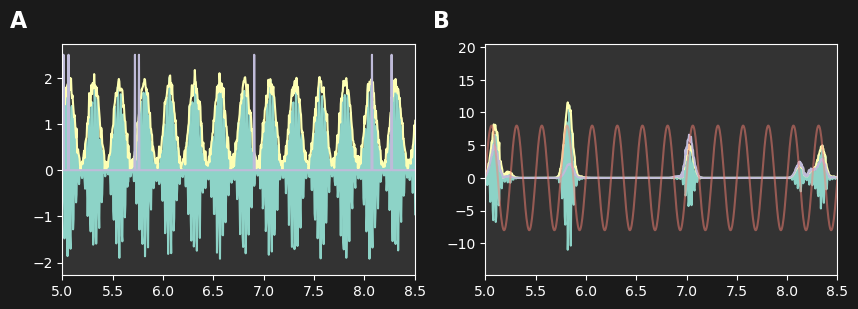

In [8]:
f, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].plot(t, signal_fast)
ax[0].plot(t, env_fast)
ax[0].plot(t, onsets*2.5)
ax[0].set_xlim([5, 8.5])

ax[1].plot(t, signal_fast_onset)
ax[1].plot(t, env_fast * modulator_onset)
ax[1].plot(t, env_fast * modulator_value)
ax[1].plot(t, signal_slow * 8, alpha=0.5)
ax[1].set_xlim([5, 8.5])

for i, label in enumerate(('A', 'B')):
    ax[i].text(-0.1, 1.15, label, transform=ax[i].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

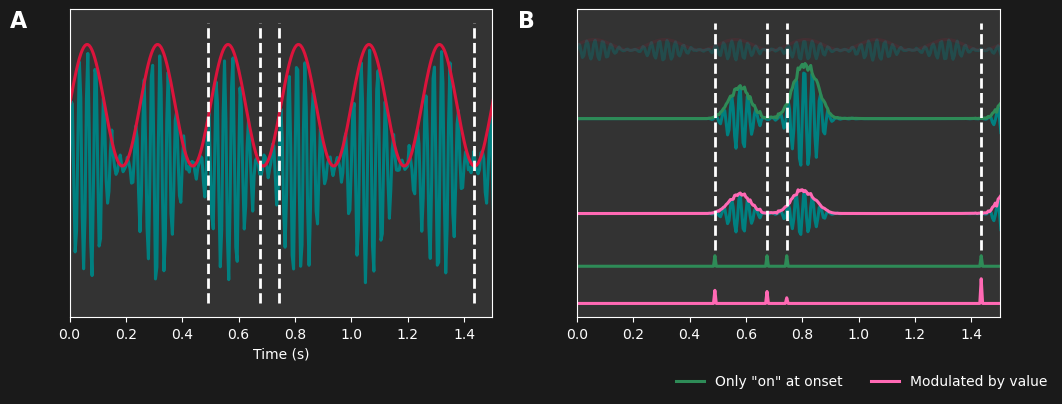

In [9]:
with plt.style.context([{'pdf.fonttype':42}, {'lines.linewidth':2.2}]):
    
    f, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Panel A
    ax[0].plot(t, signal_fast, color='teal') # modulated signal
    ax[0].plot(t, signal_slow+1, color='crimson') # modulator envelope
    ax[0].vlines(t[np.nonzero(onsets)], *ax[0].get_ylim(), color='w' if dark_bg else 'k', zorder=2, ls='--', lw=2) # onsets (irrelevant here)
    ax[0].set_xlim([0, 1.5])

    # Panel B
    ax[1].plot(t, 23 + signal_fast, color='teal', alpha=0.33) # modulated signal
    ax[1].plot(t, 23 + signal_slow +1, alpha=0.1, color='crimson') # former modulator
    ax[1].plot(t, 10 + signal_fast_onset, color='teal') # modulated signal
    ax[1].plot(t, 10 + env_fast * modulator_onset, color='seagreen') # modulator envelope via onset
    ax[1].plot(t, -8 + signal_fast_val, color='teal') # modulated signal
    ax[1].plot(t, -8 + env_fast * modulator_value, color='hotpink') # # modulator envelope via values
    ax[1].plot(t, -18 + onsets*2, 'seagreen', label='Only "on" at onset')
    ax[1].plot(t, -25 + (valued - valued.mean())*4, 'hotpink', label='Modulated by value')
    f.legend(frameon=False, ncol=2, loc='right', bbox_to_anchor=(0.85, -0.05, 0.1, -0.))
    ax[1].set_xlim([0., 1.5])
    #ax[1].set_ylim([-5, 10.])
    ax[1].vlines(t[np.nonzero(onsets)], -15, ax[1].get_ybound()[1], color='w' if dark_bg else 'k', zorder=2, ls='--', lw=2)

    for i, label in enumerate(('A', 'B')):
        ax[i].text(-0.1, 1., label, transform=ax[i].transAxes,
          fontsize=16, fontweight='bold', va='top', ha='right')

    # sns.despine(f)
    # sns.despine(ax=ax[1], left=True)
    ax[1].set_yticklabels([])
    ax[1].set_yticks([])
    # sns.despine(ax=ax[0], left=True)
    ax[0].set_yticklabels([])
    ax[0].set_yticks([])
    ax[0].set_xlabel("Time (s)")

The panel **A** shows the amplitude modulated "fast" signal. We observe there that the modulation happens irrelative to timing of events. Unlike in **B** where the modulation is only (non-zero and) occurring after those events, but always in phase with the slow signal.

We can compute the global _modulation index_ for each of the afore mentioned metrics. "Global" here means that the MI value is estimated throughout the entire time-series, thus averaging across time (and no trials). In that way, there is absolutely no notion of event timing, and therefore we cannot get a time-resolved MI.

### Estimation via TRF

In [32]:
from pyeeg.models import TRFEstimator

INFO:pyeeg:Successfully loaded makeRateMap_c Python extension module.
INFO:pyeeg:Successfully loaded gammatone_c Python extension module.


In [33]:
lags = np.arange(-0.2, 0.6 + 1/fs, 1/fs)
trf = TRFEstimator(tmin=lags[0], tmax=lags[-1], srate=fs, alpha=1e-2) # You can use this instanced class as a helper, it contains a `fit` method 
# Or if you prefer, implement a short "compute_trf_coef" functions entirely, up to you, you can find help in utils/helpers.py

# Global PAC
signal_slow, signal_pac_global, modulating_env, carrier_fast = generate_modulated_signal(t, 0.99, noise=0.06)
phase_slow = normalize_complex(hilbert(signal_slow))

# Feature-based PAC
signal_pac_onset, signal_pac_val, onsets, valued, modulator_onset, modulator_value = generate_event_modulated_signal(t, modulating_env, carrier_fast) # Reusing same slow phase signal

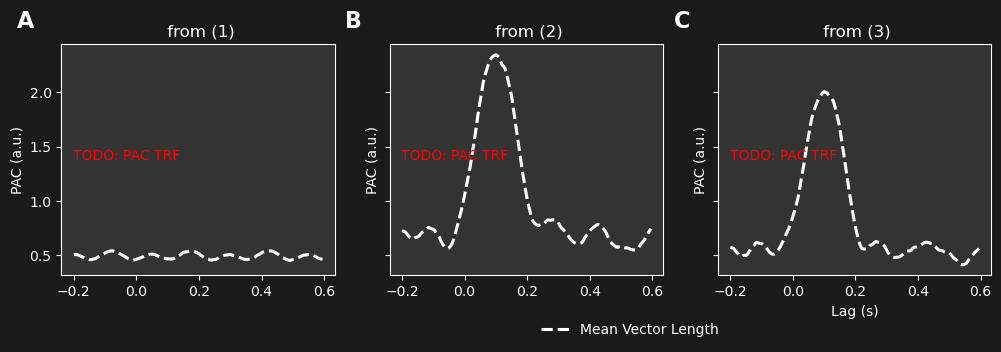

In [34]:
with plt.style.context([{'pdf.fonttype':42}, {'lines.linewidth':2.2}]):

    f, ax = plt.subplots(1, 3, figsize=(12, 3), sharey=True, dpi=100)

    # Epoch-based PAC
    for k, amp_fast in enumerate([signal_pac_global, signal_pac_onset, signal_pac_val]):
        amp_fast = abs(hilbert(amp_fast))
        ax[k].set_title(f" from ({k+1})")
        # Epoch based PAC
        epochs = []
        for ons in np.nonzero(onsets)[0]:
            if t[ons] -0.2 > t[0] and t[ons] + 0.6 < t[-1]:
                tstart = np.argmin(abs(t - (t[ons]-0.2)))
                tend = np.argmin(abs(t - (t[ons]+0.6)))
                epochs.append((amp_fast * phase_slow)[tstart:tend])
        if k==2:
             ax[2].plot(lags[:-1],  np.abs(np.stack(epochs).mean(0)), color='w' if dark_bg else 'k', ls='--', label='Mean Vector Length', zorder=0);
        else:
            ax[k].plot(lags[:-1], np.abs(np.stack(epochs).mean(0)), color='w' if dark_bg else 'k', ls='--', zorder=0);
        ax[k].set_ylabel('PAC (a.u.)')
    

    #TODO: Fit and plot PAC-TRF on onsets and valued features for Global PAC (1)
    ax[0].annotate('TODO: PAC TRF', xy=(np.mean(ax[0].get_xlim())-0.4, np.mean(ax[0].get_ylim())), color='r')
    
    #TODO: Fit and plot PAC-TRF on onsets and valued features for feature-based PAC generated from timing only (2), hint: you'll use signal_pac_onset
    ax[1].annotate('TODO: PAC TRF', xy=(np.mean(ax[1].get_xlim())-0.4, np.mean(ax[1].get_ylim())), color='r')
    
    #TODO: Fit and plot PAC-TRF on onsets and valued features for feature-based PAC generated from valued pulse-like input (3), hint: you'll use signal_pac_val-0.2
    ax[2].annotate('TODO: PAC TRF', xy=(np.mean(ax[2].get_xlim())-0.4, np.mean(ax[2].get_ylim())), color='r')

    # Legend:
    ax[2].legend(frameon=False, loc='best', bbox_to_anchor=(-0.05, -0.15, 0.1, 0.), ncol=3);

    # Some labels
    for i, label in enumerate(('A', 'B', 'C')):
        ax[i].text(-0.1, 1.15, label, transform=ax[i].transAxes,
          fontsize=16, fontweight='bold', va='top', ha='right')
    ax[2].set_xlabel('Lag (s)')

## Extra Tips

Some extra tips! As:
1. how to compute pretty much _instantly_ the TRFs for as many regularisation parameters as your computer _memory_ allows
2. or on organising the lag matrix for **banded ridge** regression, that is: different $\lambda$ for different features
3. and finally, we will also see how to _weight_ samples with whatever external signal to compute a new set of coefficients directly from the closed-form equation solution.

### 1. Computing TRFs for many regularisation parameters at once

Simply using the SVD formulation one can compute the solution for as many `alpha` regularisation parameters at once:

\begin{align}
U, S, Vt = \text{svd}(X)\\
\beta = Vt.T \text{diag}(\frac{S}{S^2 + \alpha}) U^T Y
\end{align}

or

\begin{align}
U, S, Vt = \text{svd}(X^TX)\\
\beta = U \text{diag}(\frac{1}{S + \alpha}) U^T X^T Y
\end{align}

> Also, note that if you have many participants, you could compute the equivalent of a grqand average TRF by concatenating _all X and Y_ for one big model. However this may be too much for the available RAMmemory. Instead, one can compute and store $X^TX$ and $X^TY$ (or U^TY) as we **accumulate** them, since $X^TX = \sum X_i^TX_i$ for $i$ participants.

### 2. Banded Ridge

Our deisgn matrix is already organised _per features_, meaning we built the matrix per block where diagonal block correspond to a lagged-matrix for single features. This allows to use a regularisation matrix $\mathbf{\lambda I}$ where $\mathbf{\lambda} = [\lambda_1,\dots,\lambda_2,\dots,\lambda_k,\dots,]$ with a regularisation parameter $\lambda_i$ _per feature_.

### 3. Weighted samples

We can also weight samples with a vector $\mathbf{w} \in \mathbb{R}^N$ to compute a new set of coefficients $\beta_w$. Using the diagonal matrix $\mathbf{w}$ composed of weights $\mathbf{w}$ in its diagonal:

$$
\beta_w = (X^TW^TWX)^{-1} X^TW^T Y
$$


The weights could correspond for instance to the inverse of the variance of samples across channels, some hand-engineered error signals, or any other external signals which can be used to _modulate_ the importance of samples in the computation of the TRF.

### Other solvers: Conjugate Gradient

There are many other way to find optimal coefficients for the TRF equation (1). In the tutorial, so far we used the least-square solution, sometimes regularised to minimise the L2-norm of coefficients. Other constraints exist to soleved the TRF equation, such as the L1-norm, or the L1/L2-norm; and also, other solver can be used like iterative ones such as gradient boosting (Eelbrain) or conjugate gradient. 

Below we give an example using conjugate gradient to compute the TRF coefficients while adding a L2-norm regularisation on coefficients. Note that the conjugate gradient descent on such equation can be solved in one iteration and can be even faster than SVD-based method for large matrices.

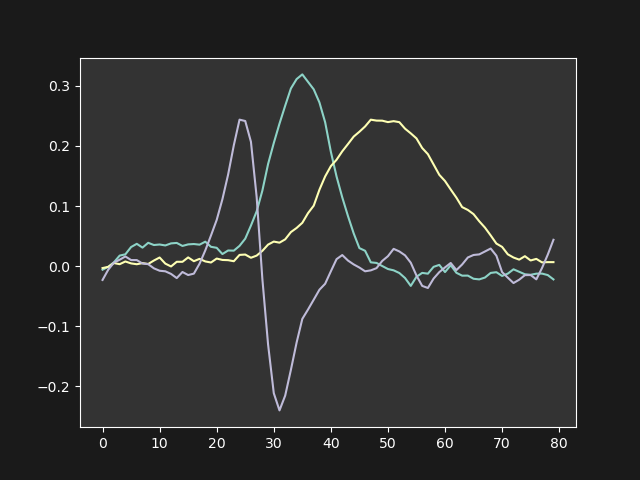

In [ ]:
plt.close('cg')
plt.figure('cg')
plt.plot(conjugate_gradient_solver(X, resp, ridge=3.0).reshape((80, 3), order='F'))